**Задача 1.** Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.



In [62]:
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error


from sklearn.ensemble import GradientBoostingRegressor


from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# !pip install lightgbm
import lightgbm as lgbm

In [63]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [64]:
data_d = data.copy().resample('W').mean()
data_d.drop(['dayofmonth','dayofyear','dayofweek','hour','is_prev_holiday','is_next_holiday'], axis=1, inplace=True)
data_d.head()

,PJME_MW,year,month,quarter,weekofyear,is_holiday
Date,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0,0.160839
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0,0.000000
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0,0.000000
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0,0.142857
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0,0.000000


**Задача 2.** Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков



Предобработка данных

In [65]:
scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_d.iloc[:,:].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

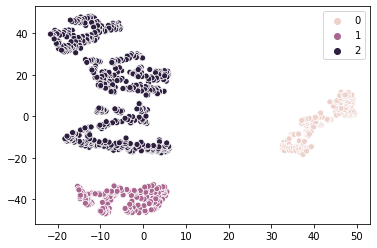

In [66]:
clast_0 = DBSCAN(eps=5, leaf_size=15)

X_clast =clast_0.fit_predict(X_t)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

In [67]:
data_d['X_clast'] = X_clast

In [68]:
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])

data_d['pca1']=Xpca[:,0]
data_d['pca2']=Xpca[:,1]

In [69]:
first_diff =np.array(data_d.iloc[1:,0].values - data_d.iloc[:-1,0].values).astype('float32') 
data_d['diff1'] = 0
data_d['diff1'] =  data_d['diff1'].astype('float') 
data_d['diff1'].values[1:] = first_diff

In [70]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [71]:
data_d['exp_0_01'] = exponential_smoothing(data_d['PJME_MW'], 0.01)
data_d['exp_0_03'] = exponential_smoothing(data_d['PJME_MW'], 0.03)
data_d['exp_0_04'] = exponential_smoothing(data_d['PJME_MW'], 0.04)
data_d['exp_0_05'] = exponential_smoothing(data_d['PJME_MW'], 0.05)
data_d['exp_0_06'] = exponential_smoothing(data_d['PJME_MW'], 0.06)
data_d['exp_0_07'] = exponential_smoothing(data_d['PJME_MW'], 0.07)
data_d['exp_0_08'] = exponential_smoothing(data_d['PJME_MW'], 0.08)

Добавим истории длиной p в признаках автокорреляции

In [72]:
p = 6
for i in range(p):
    data_d['t'+str(p-i)]=0
    data_d['t'+str(p-i)].values[p:] = data_d['PJME_MW'].values[i:-(p)+i]

Аналогично добавляем первые разности на глубину p

In [73]:
p = 6
for i in range(p):
    data_d['d'+str(p-i)]=0
    data_d['d'+str(p-i)].values[p:] = data_d['diff1'].values[i:-(p)+i]

In [74]:
h=4

scl_target=StandardScaler() 
target = data_d['PJME_MW'].values[h+p:].reshape((data_d.shape[0]-h-p,1))
y = scl_target.fit_transform(target)

scl_x=StandardScaler() 
X = data_d.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

In [75]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())

In [76]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())

In [77]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)

In [78]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 17 18 22 27]
Номера признаков лучших признаков по процентной форме:  [ 0 17 22]
Номера признаков для выбора по модели :  [ 0  2  4  7 17]


In [79]:
list_par=[0,2,4,7,17,18,22,27]
X_new = X[:,list_par]

In [80]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

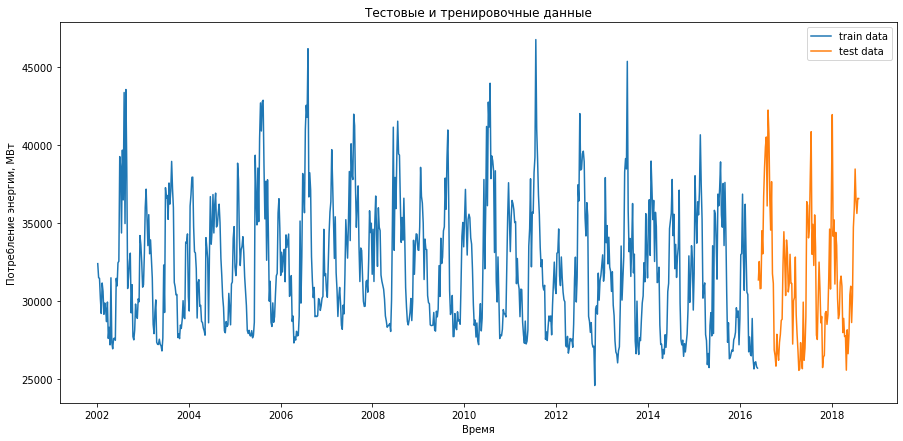

In [81]:
train, test = split_data( data_d, '05-22-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [82]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [22]:
param_dist = {'num_leaves': [15, 32, 70, 128, 150], 
              'max_depth': [1, 3, 5, 7, 10, 12, 15]}

In [23]:
model_lgbm = lgbm.LGBMRegressor()

grid_searcher = GridSearchCV(model_lgbm, param_grid=param_dist, cv=5, iid=False)

grid_searcher.fit(X_train, y_train)

C:\Users\walde\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid=False, n_jobs=None,
             param_grid={'max_depth': [1, 3, 5, 7, 10, 12, 15],
                         'num_leaves': [15, 32, 70, 128, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_tr

In [24]:
grid_searcher.best_score_, grid_searcher.best_params_

(0.6312272761923425, {'max_depth': 3, 'num_leaves': 15})

In [26]:
param_dist = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
               'n_estimators': [300, 500, 1000, 1200, 1500]}

In [27]:
model_lgbm = lgbm.LGBMRegressor(max_depth=3, num_leaves=15)

grid_searcher = GridSearchCV(model_lgbm, param_grid=param_dist, cv=5, iid=False)

grid_searcher.fit(X_train, y_train)

C:\Users\walde\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=3, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=15,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid=False, n_jobs=None,
             param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'n_estimators': [300, 500, 1000, 1200, 1500]},
             pre_dispatch='2*n_jobs', refit=True

In [28]:
grid_searcher.best_score_, grid_searcher.best_params_

(0.631471694994423, {'learning_rate': 0.01, 'n_estimators': 1000})

In [91]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [92]:
model_lgbm_h4 = lgbm.LGBMRegressor(max_depth=5, num_leaves=15, learning_rate=0.01, n_estimators=1000)
model_lgbm_h4.fit( X_train, y_train ) 
y_test_pred_g = model_lgbm_h4.predict(X_test)


mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),
                               y_pred = scl_target.inverse_transform( y_test_pred_g))

7.267055880141446

In [97]:
MAPE_h4 = np.abs((y_test[0] - y_test_pred_g[0]) / y_test[0]) * 100

MAPE_h4

52.38015095351106

**Задача 3.** Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.



In [100]:
h=1

scl_target=StandardScaler() 
target = data_d['PJME_MW'].values[h+p:].reshape((data_d.shape[0]-h-p,1))
y = scl_target.fit_transform(target)

scl_x=StandardScaler() 
X = data_d.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

In [101]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())

In [102]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())

In [103]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)

In [104]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 19 20 21 22]
Номера признаков лучших признаков по процентной форме:  [ 0 21 22]
Номера признаков для выбора по модели :  [0]


In [105]:
list_par=[0,19,20,21,22]
X_new = X[:,list_par]

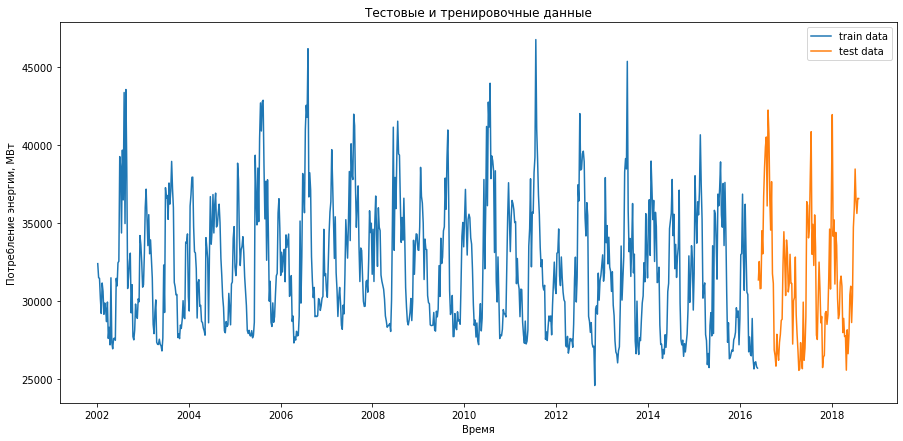

In [106]:
train, test = split_data( data_d, '05-22-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [107]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [108]:
X_test.shape

(108, 5)

In [109]:
param_dist = {'num_leaves': [15, 32, 70, 128, 150], 
              'max_depth': [1, 3, 5, 7, 10, 12, 15]}

In [43]:
model_lgbm = lgbm.LGBMRegressor()

grid_searcher = GridSearchCV(model_lgbm, param_grid=param_dist, cv=5, iid=False)

grid_searcher.fit(X_train, y_train)

C:\Users\walde\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid=False, n_jobs=None,
             param_grid={'max_depth': [1, 3, 5, 7, 10, 12, 15],
                         'num_leaves': [15, 32, 70, 128, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_tr

In [44]:
grid_searcher.best_score_, grid_searcher.best_params_

(0.6403582786160835, {'max_depth': 1, 'num_leaves': 15})

In [45]:
param_dist = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
               'n_estimators': [300, 500, 1000, 1200, 1500]}

In [46]:
model_lgbm = lgbm.LGBMRegressor(max_depth=1, num_leaves=15)

grid_searcher = GridSearchCV(model_lgbm, param_grid=param_dist, cv=5, iid=False)

grid_searcher.fit(X_train, y_train)

C:\Users\walde\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=15,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid=False, n_jobs=None,
             param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'n_estimators': [300, 500, 1000, 1200, 1500]},
             pre_dispatch='2*n_jobs', refit=True

In [47]:
grid_searcher.best_score_, grid_searcher.best_params_

(0.6453746271478531, {'learning_rate': 0.05, 'n_estimators': 500})

In [110]:
model_lgbm_h1 = lgbm.LGBMRegressor(max_depth=5, num_leaves=15, learning_rate=0.05, n_estimators=500)
model_lgbm_h1.fit( X_train, y_train ) 
y_test_pred_g = model_lgbm_h1.predict(X_test)


mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),
                               y_pred = scl_target.inverse_transform( y_test_pred_g))

7.401998263962518

**Задача 4.** Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.



In [111]:
data_d.columns[list_par]

Index(['PJME_MW', 't4', 't3', 't2', 't1'], dtype='object')

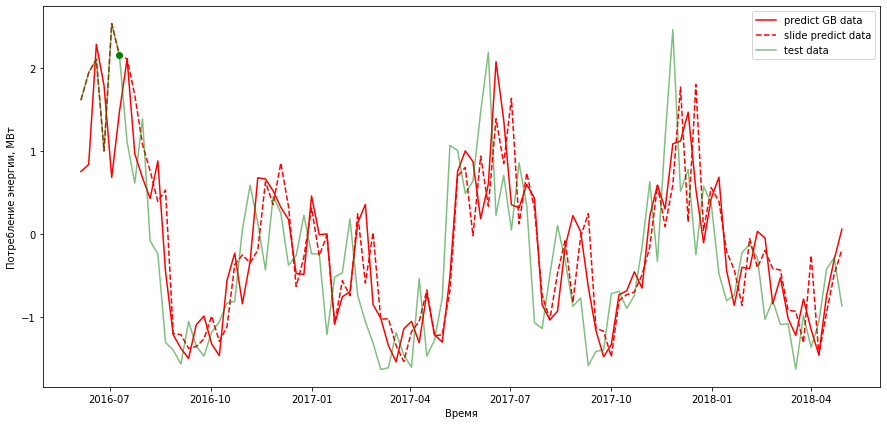

In [112]:
X_test_100 = X_test.copy()
y_test_100 = y_test.copy()
N10 = 100
for i in range(p,N10+p):
    y_test_100[i] = model_lgbm_h1.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
    # обновим историю значенний
    X_test_100[i+1,1] = X_test_100[i-4,0]
    X_test_100[i+1,2] = X_test_100[i-3,0]
    X_test_100[i+1,3] = X_test_100[i-2,0]
    X_test_100[i+1,4] = X_test_100[i-1,0]
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.legend()
plt.show()   

In [113]:
mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[p:N10]),
                                y_pred = scl_target.inverse_transform( y_test_100[p:N10]))

7.981538081733462

In [115]:
MAPE_h1 = np.abs((y_test[p+4] - y_test_pred_g[p+4]) / y_test[4]) * 100

MAPE_h1

44.22594713586736

**Задача 5.** Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)



In [58]:
intervals = [i for i in range(p,len(y_test),10)]

In [61]:
for i in range(1,len(intervals)):
    MAPE = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[intervals[i-1]:intervals[i]]),
                                y_pred = scl_target.inverse_transform( y_test_100[intervals[i-1]:intervals[i]]))
    
    print(f'MAPE для интервала наблюдений от {intervals[i-1]} до {intervals[i]} составила {round(MAPE,2)}%')

MAPE для интервала наблюдений от 6 до 16 составила 8.59%
MAPE для интервала наблюдений от 16 до 26 составила 5.35%
MAPE для интервала наблюдений от 26 до 36 составила 7.26%
MAPE для интервала наблюдений от 36 до 46 составила 8.8%
MAPE для интервала наблюдений от 46 до 56 составила 8.04%
MAPE для интервала наблюдений от 56 до 66 составила 8.67%
MAPE для интервала наблюдений от 66 до 76 составила 7.62%
MAPE для интервала наблюдений от 76 до 86 составила 11.03%
MAPE для интервала наблюдений от 86 до 96 составила 7.18%
MAPE для интервала наблюдений от 96 до 106 составила 5.62%


**Задача 6.** Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Вопреки ожиданиям, ошибка ведет себя так, будто не зависит от горизонта прогнозирования ...